# Systemy Wizyjne

## Ćwiczenie laboratoryjne – Bag of Visual Words




## Wstęp teoretyczny

### Zadanie 1: 

Uzupełnij zdanie: "Na każdych zajęciach obowiązuje..." 

(poprawna odpowiedź znajduje się komórce niżej – ale proszę ją sprawdzić dopiero po przygotowaniu własnego rozwiązania).

### Odpowiedź

"...znajomość materiału zaprezentowanego na wykładzie".


Jak można było wywnioskować z tytułu, tematem aktualnych zajęć będzie wykorzystanie modelu Bag of Words. Wywodzi się on z NLP (przetwarzania języka naturalnego) i służy do (uproszczenia) reprezentacji danych poprzez przedstawienie ich jako częstość (histogram) występowania poszczególnych słów (ograniczonych przez pewien wcześniej stworzony słownik).

W przypadku przetwarzania obrazów, rolę słów "lądujących w worku" pełnią cechy wyodrębnione z obrazu – zazwyczaj poprzez znane i sprawdzone "tradycyjne" detektory/deskryptory (jak SURF czy AKAZE).

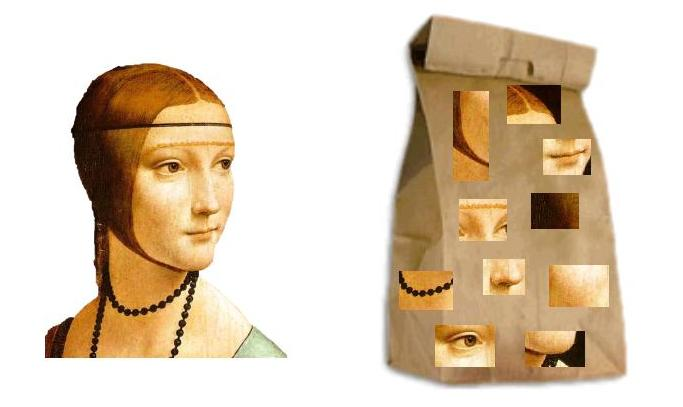


Samo Bag of (Visual) Words jest jednak tylko modelem reprezentacji/transformacji oryginalnych danych – które są później wykorzystywane przez docelowe algorytmy klasyfikacji/regresji uczenia maszynowego (jak te, które poznaliśmy na zajęciach wcześniejszych).

## Zbiór danych

Machine learning bez danych jest zdecydowanie utrudniony – dlatego zacznijmy od zaopatrzenia się w nie.

W Chmurze PP pod poniższym linkiem znajduje się dataset z którym będziemy pracować: https://chmura.put.poznan.pl/s/M18ASZYzUrpgkr0/download.

Zawiera on dwie klasy zdjęć: okręty typu żaglówka (dobre na relaksujące rodzinne wycieczki) i okręty wojenne (jeszcze lepsze na relaksujące rodzinne wycieczki).
Poniżej można zobaczyć próbki z obu wymienionych:

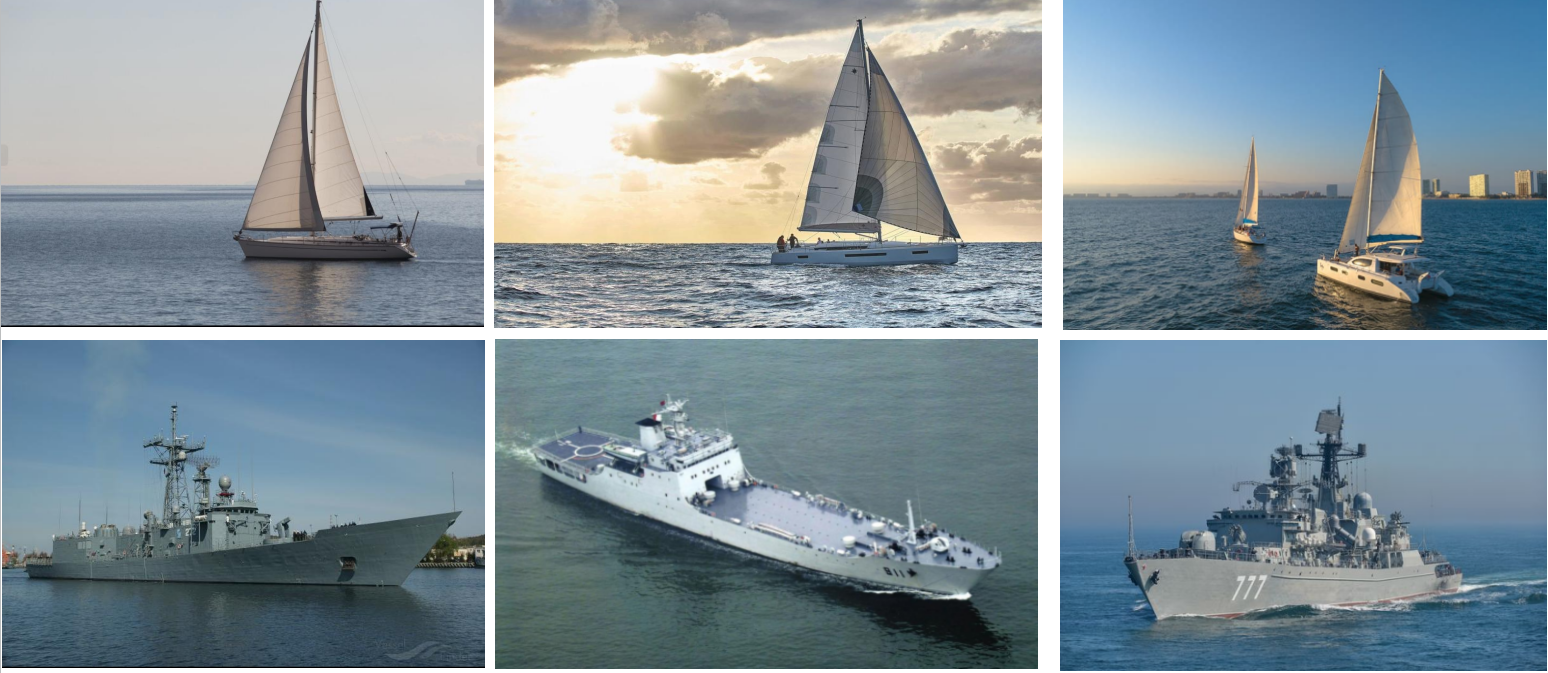

<b>TODO 4YOU</b>

Widoczna w komórce wyżej próbka jest tylko częścią zdjęć z naszych dostępnych danych – zadbaj o to, żebyś mogła/mógł przeglądać je wszystkie.

Wczytaj wszystkie dostępne zdjęcia do pamięci, jednocześnie tworząc odpowiedni wektor, w którym zakodowane będą w postaci liczb całkowitych klasy odpowiadające poszczególnym próbkom (na późniejsze potrzeby). Wyświetl parę (można wszystkie, nie ma ich aż tak dużo) przykładów zdjęć dla obu klas.


## Przygotowanie "słownika"

W ogólności, nam jako ludziom nie sprawia problemu rozróżnienie pomiędzy tymi dwiema klasami. Napisanie abstrakcyjnego kodu, który pozwolił by go w teorii rozwiązać też jest w naszych możliwościach:


```
if żagle in image and len(statek.dziala) == 0:
    is_zaglowka = 'yup'
else:
    is_zaglowka = 'nope'
```

Zdecydowanie gorzej natomiast było by ze szczegółową implementacją – jak określić czy na obrazie jest żagiel? Porównywać wartości różnych pixeli? Jeśli tak to jakich konkretnie, co z faktem, że żagiel może być w różnych miejscach obrazu, etc, etc. Generalnie zadanie to zdecydowanie lepiej oddelegować metodom automatycznym – np. znanym nam już z wykładów detektorom/deskryptorom cech obrazowych.



OpenCV zawiera w sobie implementacje wielu "tradycyjnych" detektorów/deskryptorów cech. Aby z nich skorzystać, wystarczy utowrzyć odpowiedni obiekt:

In [ ]:
import cv2

feature_detector_descriptor = cv2.AKAZE_create()

Wszystkie detektory/deskryptory w opencv mają wspólne, wysokopoziomowe API. Do ich tworzenia służą fukcje w schemacie takim jak ta przedstawiona powyżej:
<b>cv2.X_create()</b>, gdzie za <b>X</b> podstawiamy nazwę detektora/deskryptora który nas interesuje, np. ORB czy AKAZE.

Aby obliczyć deskryptor wczytanego wcześniej obrazu, można się posłużyć następującą metodą:

In [ ]:
from skimage import data

# Alternatywny sposób na konwersję RGB do BGR
image = data.astronaut()[..., ::-1]


keypoints, image_descriptors = feature_detector_descriptor.detectAndCompute(image, None)  
# Drugim argumentem może być maska binarna, która służy do zawężenia obszaru z którego
# uzyskujemy punkty kluczowe/deskryptor – jako, że nam akurat zależy na całym obrazie,
# podaliśmy tam wartość None.

In [ ]:
# Wynikiem jest lista punktów kluczowych oraz odpowiadającym im wektorów – które składają się na deskryptor.
len(keypoints), len(image_descriptors)

(870, 870)

In [ ]:
keypoints[0]

<KeyPoint 0x7f63ce2dbea0>

In [ ]:
[attr for attr in dir(keypoints[0]) if not attr.startswith('__')]

['angle', 'class_id', 'convert', 'octave', 'overlap', 'pt', 'response', 'size']

In [ ]:
image_descriptors[0]

array([160,   6,   2,  24,  14,   0,  56, 249,  61,   7, 254,   0,   0,
       136,  63,   0,   6, 128,   1, 112,   6, 255,   0,   0,   0,  24,
        56,  28,   0,   0,  31,  34, 132, 184,  87, 255, 245,  15, 128,
       255, 221, 255,   3, 122, 255,  37,   0,   0,   0, 224,   0,  14,
       115, 252,   1,   2,   0, 252, 255,  63,   0], dtype=uint8)

To właśnie z takich wektorów, opisujących cechy obrazowe chcemy stworzyć nasz 
słownik. Zanim przejdziemy jednak to jego właściwego tworzenia – podzielmy jeszcze dane na odpowiednie podzbiory.

<b>TODO4YOU</b>

Podziel dane "zgodnie ze sztuką" tj. na zbiór treningowy, walidacyjny i testowy.
Pamiętaj o odpowiednich proporcjach (sugerowana dystrybucja to 60%/20%/20%). 


"Słownik" naszego BoVW będziemy przygotowywać korzystając tylko ze zbioru treningowego, natomiast sama jego "aplikacja"/przeprowadzanie transformacji dotyczyć będzie już wszystkich zbiorów.

W związku z tym, że pracujemy na danych obrazowych i cechach z nich wyekstrahowanych, musimy mieć na uwadze jeszcze dwa aspekty:
* w przeciwieństwie do języka naturalnego nasz "słownik" cech nie może być słownikiem z idealnym odwzorowaniem 1 do 1 – deskryptory są przecież długimi wektorami i perfekcyjne dopasowanie jest stosunkowo mało prawdopodobne,
* musimy ograniczyć też w pewien sposób liczbę "słów" – już po przetransformowaniu przykładowego obrazu uzyskaliśmy ich aż 870, a próbek w zbiorze treningowym mamy znacznie więcej.

Oba te problemy można rozwiązać jednym, prostym sposobem (<s>ODKRYŁ JEDEN PROSTY TRIK! NAUKOWCY GO NIENAWIDZĄ! [ZOBACZ JAK!](https://www.youtube.com/watch?v=dQw4w9WgXcQ)</s>) – nie używając konkretnych cech z obrazów ze zbioru treningowego, a raczej stworzonego na ich podstawie zgrupowania/klastrów.

<b>TODO4YOU</b>

Na podstawie wcześniej wydzielonego zbioru treningowego, przygotuj nasz "słownik" cech wizyjnych. W tym celu:
* użyj najpierw wybranego wcześniej detektora/deskryptora cech na wszystkich obrazach ze zbioru treningowego, wyodrębniając z niego wszystkie wykryte cechy,
* używając zebranych cech przygotuj/wytrenuj model klastrujący. Skorzystaj z biblioteki sklearn, niech użytym algorytmem będzie KMeans. Zadana jako hiperparametr liczba klastrów odpowiada "pojemności" słownika – ile słów będzie się w nim znajdować. Później będzie można skorzystac z metody <i>predict</i>, aby podając wykryte cechy otrzymać do jakich słów są one przyporządkowane (a w dalszej kolejności również to zliczyć – co jest naszym ostatecznym celem).


In [ ]:
from sklearn import cluster


NB_WORDS = 20

## Aplikacja "słownika" – transformacja obrazu do histogramu słów

Mając przygotowany nasz model klastrujący możemy przejść do finalnego etapu transformacji danych – zliczenia poszczególnych słów.

<b>TODO4YOU</b>

Napisz funkcję, która będzie przyjmować dwa argumenty: wyodrębnione z obrazu deskryptory (listę wektorów opisujących wykryte punkty kluczowe) oraz przygotowany model klastrujący.

Niech przygotowuje ona histogram liczności "słów" w danym obrazie. W tym celu powinna ona:
* użyć modelu klastrującego, aby stwierdzić do których słów najbardziej pasują dane deskryptory,
* zliczyć zwrócone przez model liczoności słów, tworząc ich histogram.

<b>Wskazówka</b>: histogram powinien mieć taką samą liczbę kubełków co liczba dostępnych wizualnych słów w naszym wcześniej przygotowanym słowniku.

<b>Wskazówka</b>: Poszczególne obrazy mogą się znacznie różnić tym, ile cech zostanie w nich wykrytych przez detektor/deskryptor – dlatego zamiast liczności "absolutnej" lepiej by było, aby histogram był w jakiś sposób znormalizowany (np. poprzez przedstawianie procent poszczególnych słów w danym deskryptorze obrazu).


In [ ]:
def convert_descriptors_to_histogram(descriptors, vocab_model):
  ...
  return histogram


<b>TODO4YOU</b> 

Teraz przygotowaną funkcję należy zaaplikować na wszystkich próbkach danych wejściowych – zarówno ze zbioru treningowego, jak i walidacyjnego/testowego
(dobrze było by do tego przygotować kolejną funkcję pomocniczą – aczkolwiek nie
jest to obowiązkowe).

In [ ]:
def apply_feature_transform(images, feature_detector_descriptor, vocab_model):
  ...
  return histograms


## Ostatnia prosta – finalna klasyfikacja

Teraz, gdy przygotowaliśmy już nasze dane, poprzez przeprowadzenie odpowiednich transformacji cech, ostatnia część, trening samego klasyfikatora jest już stosunkowo prosta – przynajmniej w wersji podstawowej:


In [ ]:
from sklearn.tree import DecisionTreeClassifier  # Oczywiście możemy zastąpić DT w zasadzie dowolnym klasyfikatorem.


classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
print(classifier.score(X_test, y_test))

<b>TODO4YOU</b>

* Domyślny model zastosowany powyżej na pewno da się jeszcze (znacząco). Wykorzystaj algorytm grid search, żeby dobrać jak najlepszy rodzaj klasyfikatora i jego hiperparametry.
* Jak już było wspomniane, zwykłe accuracy zazwyczaj nie jest najlepszą metryką.
Stwórz macierz pomyłek i jej wizualizację (jest do tego w sklearn dedykowana funkcja), żeby sprawdzić jak wygląda rozkład poszczególnych typów błędów (TP, FN, ...).
* Tym razem, oprócz samego klasyfikatora, mamy też większe niż wcześniej możliwości "tuningowania" w jaki konkretnie sposób przygotowujemy cechy.
Sprawdź w analogiczny jak wcześniej sposób, jak na wyniki wpyłnie zmiana parametrów wielkości naszego "worka" – spróbuj z takimi liczbami słów jak 5, 25, 50 i 100.
* Przedstaw graficznie (używając matplotliba) zależność czasu przygotowania słownika/treningu do uzyskanych wartości metryk. Jakie są Twoje wnioski? Czy zawsze poprawa jest proporcjonalna do poniesionego kosztu?


<b>Dla chętnych</b>: można też sprawdzić wpływ na wyniki deskryptorów/detektorów cech innych niż domyślnie stworzone AKAZE. <br/>
<b>Uwaga</b>: wykorzystanie nie wszystkich dostępnych w OpenCV detektorów/deskryptorów ma sens w kontekście BoVW – należy się trochę odwołać do wiedzy na ich temat z wykładu.<br/>
<b>Wskazówka</b> SIFT i SURF nie są domyślnie dostępne w aktualnych wersjach Opencv (z uwagi na prawa patentowe) – aby je wypróbować potrzebne jest zainstalowanie <i>opencv-python-contrib</i> (sytuacja jest zmienna, w razie czego oba algorytmy były dostępne w wersji).
